In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.special import logsumexp
from scipy.stats import norm
import random

# Set some defaults
plt.rc("axes.spines", top=False, right=False)

sns.set_theme(context="paper", font_scale=1.2)
sns.set_style("ticks")

# Import python library/function for function optimization
import scipy.optimize

%config InlineBackend.figure_format = "retina"

In [2]:
# Read in vmr data
df = pd.read_csv("../results/vmr_all.csv")
df.head()

,si,SN,id,tester,TN,move_cycle,hX,hY,rot_hX,rot_hY,...,RT,ST,adaptation,total error,theta_maxradv_z,theta_maxradv_outlier,theta_maxradv_mean,theta_maxradv_clean,motor_sd,perturbation
0,1,1,01_i,s,72,72,5.646301,90.778669,0.0,0.0,...,0.323414,1.054281,NaN,NaN,2.507849,False,1.076975,6.542682,1.661801,False
1,1,1,01_i,s,73,73,4.886301,88.328669,0.0,0.0,...,0.309482,1.084872,-2.337005,-2.972700,-0.007217,False,1.076975,1.027300,1.661801,True
2,1,1,01_i,s,74,74,5.006301,91.668669,0.0,0.0,...,0.356222,1.100153,NaN,NaN,1.442153,False,1.076975,4.205676,1.661801,False
3,1,1,01_i,s,75,75,2.246301,90.208669,0.0,0.0,...,0.276952,1.339061,-0.427851,1.467717,1.105636,False,1.076975,3.467717,1.661801,True
4,1,1,01_i,s,76,76,1.716301,87.748669,0.0,0.0,...,0.241043,1.486548,NaN,NaN,1.247048,False,1.076975,3.777826,1.661801,False


In [3]:
def state_ege(previous_state, ege, T, B, A=0):
    state_est = A * previous_state + B * (T - ege)
    
    return state_est


def pea(x_v, sigma_v, sigma_int, T, B):
    w_int = (1 / sigma_int**2) / (1 / sigma_int**2 + 1 / sigma_v**2)
    w_v = (1 / sigma_v**2) / (1 / sigma_int**2 + 1 / sigma_v**2)
    xhat_hand = w_v * x_v
    x_stl = B * (T - xhat_hand)
    
    return x_stl


def simulate_experiment(num_trials, x_hand_ege, sigma, vis_fb, delta_x, B):
    for i in range(num_trials - 1):
        if i == 0:
            x_hand_ege[i] = np.random.normal(0, sigma)

        if vis_fb[i] == 0:
            x_v = 0
            ege = 0
        else:
            ege = delta_x[i] 

        x_hand_ege[i + 1] = state_ege(x_hand_ege[i], ege, T, B) + np.random.normal(0, sigma)
    
    return x_hand_ege


def calculate_adaptation(num_trials, n_per_miniblock, x):
    adaptation = np.zeros(num_trials)
    adaptation[1::n_per_miniblock] = x[2::n_per_miniblock] - x[0:-1:n_per_miniblock]
    
    return adaptation

In [4]:
# Plotting functions
def plot_individual(df, ege, ige, adaptation, color="k", title=None):
    fig, axs = plt.subplots(1, 2, figsize=(6, 4))
    sns.regplot(data=df, x=ege, x_jitter=0.1, y=adaptation, 
               scatter_kws={"alpha":0.4, "color":"gray"},  line_kws={"color":color}, ax=axs[0])
    axs[0].set(xlabel="Rotation ($^\circ$)", ylabel="Adaptive response ($^\circ$)", 
               xlim=[-6, 6], xticks=np.arange(-4, 4.01, 2), ylim=[-10, 10], 
               yticks=np.arange(-10, 10.01, 2))
    axs[0].axhline(color="k", linewidth=0.5)

    sns.regplot(data=df, x=ige, y=adaptation, line_kws={"color":color}, 
                scatter_kws={"alpha":0.4, "color":"gray"}, ax=axs[1])
    axs[1].set(ylim=[-10, 10], yticks=np.arange(-10, 10.01, 2), xlim=[-6, 6], 
               xticks=np.arange(-4, 4.01, 2), xlabel="Motor noise ($^\circ$)", 
               ylabel="Adaptive response ($^\circ$)")
    axs[1].axhline(color="k", linewidth=0.5)
    
    sns.despine()
    fig.suptitle(title)
    plt.tight_layout()
    
    return fig

---
# Maximum Likelihoood Estimation

In [5]:
# Read in vmr data
df = pd.read_csv("../results/vmr_all.csv")
df.head()

,si,SN,id,tester,TN,move_cycle,hX,hY,rot_hX,rot_hY,...,RT,ST,adaptation,total error,theta_maxradv_z,theta_maxradv_outlier,theta_maxradv_mean,theta_maxradv_clean,motor_sd,perturbation
0,1,1,01_i,s,72,72,5.646301,90.778669,0.0,0.0,...,0.323414,1.054281,NaN,NaN,2.507849,False,1.076975,6.542682,1.661801,False
1,1,1,01_i,s,73,73,4.886301,88.328669,0.0,0.0,...,0.309482,1.084872,-2.337005,-2.972700,-0.007217,False,1.076975,1.027300,1.661801,True
2,1,1,01_i,s,74,74,5.006301,91.668669,0.0,0.0,...,0.356222,1.100153,NaN,NaN,1.442153,False,1.076975,4.205676,1.661801,False
3,1,1,01_i,s,75,75,2.246301,90.208669,0.0,0.0,...,0.276952,1.339061,-0.427851,1.467717,1.105636,False,1.076975,3.467717,1.661801,True
4,1,1,01_i,s,76,76,1.716301,87.748669,0.0,0.0,...,0.241043,1.486548,NaN,NaN,1.247048,False,1.076975,3.777826,1.661801,False


In [6]:
from scipy.stats import norm

def ssm_ege(B, sigma_motor, rotation):
    '''
    Returns: 
        mu : state estimate
        x : motor output
    '''
    e = np.zeros(len(rotation))
    mu = np.zeros(len(rotation))
    x = np.zeros(len(rotation))
    
    for i in range(1, len(rotation)):
        if i == 0:
            mu[i] = 0
        else:
            e[i - 1] = rotation[i - 1]
            mu[i] = B * e[i - 1]
        
        x[i] = mu[i] + np.random.normal(0, sigma_motor)
    
    return mu, x


def pea(sigma_int, B, sigma_motor, num_trials, vis_fb, rotation, fit=False, x_hand=None):
    '''
    Returns:
        x_stl : state estimate
        x_hand : motor output
    '''
    T = 0
    x_stl = np.zeros(num_trials)
    
    if fit == True:
        x_hand = x_hand
    else:
        x_hand = np.zeros(num_trials)
    
    for i in range(num_trials - 1):
        if vis_fb[i] == 0:
            x_v = 0
            sigma_v = np.inf
        else:
            x_v = x_hand[i] + rotation[i]
            sigma_v = 1.179 + 0.384 * np.abs(x_v)  # after Zhang et al
        
        # Compute estimated hand position
        w_int = (1 / sigma_int**2) / (1 / sigma_int**2 + 1 / sigma_v**2)
        w_v = (1 / sigma_v**2) / (1 / sigma_int**2 + 1 / sigma_v**2)
        xhat_hand = w_v * x_v 
        
        # Update rule
        x_stl[i + 1] = B * (T - xhat_hand)
        if fit == False:
            x_hand[i + 1] = x_stl[i + 1] + np.random.normal(0, sigma_motor)
        
    return x_stl, x_hand


def premo(B, sigma_v, sigma_p, sigma_pred, eta_p, sigma_motor, 
          num_trials, vis_fb, rotation, fit=False, x_hand=None):
    '''
    Model parameters
        B
        sigma_v
        sigma_p
        sigma_pred
        eta_p
    '''
    
    beta_p_sat = 5
    T = 0
    x_stl = np.zeros(num_trials)
    sigma_u = sigma_pred
    
    if fit == True:
        x_hand = x_hand
    else:
        x_hand = np.zeros(num_trials)
    
    for i in range(num_trials - 1):
        if vis_fb[i] == 0:
            x_v = 0
            sigma_v = 1e2
        else:
            x_v = x_hand[i] + rotation[i]
        x_p = x_hand[i]
        
        # Precisions
        J_v = 1 / sigma_v**2
        J_p = 1 / sigma_p**2
        J_u = 1 / sigma_u**2
  
        # Weights for each modality
        w_v = J_v / (J_v + J_u)
        w_p = J_p / (J_p + J_u)
    
        # beta_p is proprio shift due to crossmodal recal from vision
        if x_v > x_p:
            beta_p = np.min([np.abs(beta_p_sat), np.abs(eta_p * (w_v * x_v - w_p * x_p))])
        else:    
            beta_p = -np.min([np.abs(beta_p_sat), np.abs(eta_p * (w_v * x_v - w_p * x_p))])
        x_prop_per = w_p * x_p + beta_p  # Perceived hand position 

        x_stl[i + 1] = B * (T - x_prop_per)
        if fit == False:
            x_hand[i + 1] = x_stl[i + 1] + np.random.normal(0, sigma_motor)
    
    return x_stl, x_hand


def rem(B, sigma_comb, s, c, sigma_motor, num_trials, vis_fb, rotation, 
        fit=False, x_hand=None):
    '''
    Model parameters
        B
        sigma_Comb
        s 
        c
    '''
    
    T = 0
    x_stl = np.zeros(num_trials)
    
    if fit == True:
        x_hand = x_hand
    else:
        x_hand = np.zeros(num_trials)
    
    for i in range(num_trials - 1):
        if vis_fb[i] == 0:
            x_v = 0
        else:
            x_v = x_hand[i] + rotation[i]
        x_p = x_hand[i]

        p_rel = s * norm.pdf(x_v, loc=x_v, scale=sigma_comb) / (norm.pdf(x_v, loc=x_v, scale=sigma_comb) + c)
        x_stl[i + 1] = B * (T - p_rel * x_v)
        if fit == False:
            x_hand[i + 1] = x_stl[i + 1] + np.random.normal(0, sigma_motor)
        
    return x_stl, x_hand


def negloglik_test(B=None, sigma_motor=None, sigma_int=None, sigma_pert=None, 
                   sigma_pred=None, sigma_p=None, sigma_v=None, sigma_comb=None,
                   s=None, c=None, model=None, num_trials=None, rotation=None, 
                   fit=True,  vis_fb=None, eta_p=None, beta_p_sat=None, x_hand=None):
    if model == "pea":
        mu, _ = pea(sigma_int, B, sigma_motor, num_trials, vis_fb, rotation, 
                    fit, x_hand=x_hand)
    elif model == "piece":
        mu, _ = piece(sigma_pert, sigma_pred, sigma_p, sigma_motor, num_trials, 
                      vis_fb, rotation, fit, x_hand=x_hand)
    elif model == "ssm":
        mu, _ = ssm_ege(B, sigma_motor, rotation)
    elif model == "premo":
        mu, _ = premo(B, sigma_v, sigma_p, sigma_pred, eta_p, sigma_motor, 
                      num_trials, vis_fb, rotation, fit, x_hand=x_hand)
    elif model == "rem":
        mu, _ = rem(B, sigma_comb, s, c, sigma_motor, num_trials, vis_fb, rotation, 
                    fit, x_hand=x_hand)
    
    nll = -np.sum(-1 / 2 * np.log(2 * np.pi * sigma_motor**2) - ((x_hand - mu)**2 / (2 * sigma_motor**2)))
    
    return nll


In [7]:
def piece(sigma_pert, sigma_pred, sigma_p, sigma_motor, num_trials, vis_fb, rotation, fit=False, x_hand=None):
    '''
    Model parameters
        sigma_pert
        sigma_pred
        sigma_p
        sigma_motor
         
    Returns
        x_state : state estimate
        x_f : motor output
    '''
    
    # Function for computing Gaussian log-probabilities
    f = lambda x, mu, sigma: -0.5 * np.log(2 * np.pi * sigma**2) - 0.5 * (x - mu)**2 / sigma**2
    
    # Possible endpoint locations
    x_grid = np.arange(-15, 15, 0.1)  

    # For vectorized code
    x_fs = x_grid.reshape((len(x_grid), 1))  # possible finger endpoint locations (col vec)
    d_xvs = x_grid.reshape((1, len(x_grid)))  # possible rotation sizes (row vec)
    x_vs = x_grid  # possible locations of visual cues
    x_ps = x_grid  # possible locations of proprioceptive cues
    x_us = x_grid  # possible locations of predictive cues

    # Ideal observer     
    x_f_hat = np.zeros(num_trials)
    x_state = np.zeros(num_trials)
    sigma_v = np.zeros(num_trials)
    K = np.zeros(num_trials)
    like_nopert_analytical = []
    mu_pert = 0
    b = 0
    prior_pert = 0.5
    
    # If fitting model to data, use actual hand data
    if fit == True:
        x_f = x_hand
    else: 
        x_f = np.zeros(num_trials) 
        x_f[0] = np.random.normal(0, sigma_motor)
    
    # Loop through trials
    for i in range(num_trials - 1):
        xhat_pred = x_f[i]
        xhat_p = x_f[i]

        if vis_fb[i] == 0:
            xhat_v = 0
            sigma_v[i] = 1e2
        else:
            xhat_v = x_f[i] + rotation[i]
            sigma_v[i] = 1.179 + 0.384 * np.abs(xhat_v)  # After Zhang et al 
        J_v = 1 / sigma_v[i]**2
        J_pert = 1 / sigma_pert**2
        K[i] = J_v / (J_v + J_pert)

        # Compute no perturbation likelihood (working with log-probs for numerical accuracy)
        loglik_nopert = (
            f(xhat_pred, x_fs, sigma_pred) + f(xhat_v, x_fs, sigma_v[i]) 
            + f(xhat_p, x_fs, sigma_p) + f(x_fs, b, sigma_motor) 
        )
        loglik_nopert = logsumexp(loglik_nopert.flatten(), b=0.1)
        likelihood_nopert = np.exp(loglik_nopert)

        # Compute perturbation likelihood
        loglik_pert = (
            f(xhat_pred, x_fs, sigma_pred) + f(xhat_v, x_fs + d_xvs, sigma_v[i]) 
            + f(xhat_p, x_fs, sigma_p) + f(d_xvs, mu_pert, sigma_pert) 
            + f(x_fs, b, sigma_motor)  
        )
        loglik_pert = logsumexp(loglik_pert.flatten(), b=0.01)
        
        # To account for no vis fb trials
        if vis_fb[i] == 1:
            likelihood_pert = np.exp(loglik_pert)
        else:
            likelihood_pert = 0

        # Posterior over Causal node
        normalization_const = prior_pert * likelihood_pert + ((1 - prior_pert) * likelihood_nopert)
        post_pert = (prior_pert * likelihood_pert) / normalization_const  # Posterior over Cause

        # Simulate trial-by-trial adaptation
        x_state[i + 1] = post_pert * K[i] * (rotation[i]) * -1
        if fit == False: 
            x_f[i + 1] = x_state[i + 1] + np.random.normal(0, sigma_motor)
        
    return x_state, x_f


In [8]:
def calc_bic(ll, num_params, num_trials):
    bic = -2 * ll + num_params * np.log(num_trials)
    
    return bic

In [20]:
%%time 
subj_num = []
model = []
theta = []
loglik = []
bic = []
delta_bic = []

# Fit models to data
for i in range(len(np.unique(df["SN"]))):
    subj = df.loc[df["SN"] == i + 1, :]
    
    # Extract important variables
    motor_sd = subj["motor_sd"].iloc[0]
    x_hand = subj["theta_maxradv_clean"].values
    rotation = subj["rotation"].values
    vis_fb = subj["fbi"].values

    # Define cost functions
    nll_pea = lambda x: negloglik_test(model="pea", sigma_int=x[0], B=x[1],  
                                       sigma_motor=motor_sd, num_trials=len(subj), 
                                       vis_fb=vis_fb, rotation=rotation, x_hand=x_hand)
    nll_premo = lambda x: negloglik_test(model="premo", B=x[0], sigma_pred=x[1], 
                                         sigma_v=x[2], sigma_p=x[3], eta_p=x[4], 
                                         sigma_motor=motor_sd, num_trials=len(subj), 
                                         vis_fb=vis_fb, rotation=rotation, 
                                         x_hand=x_hand)
    nll_piece = lambda x: negloglik_test(model="piece", sigma_pert=x[0], sigma_pred=x[1], 
                                         sigma_p=x[2], sigma_motor=motor_sd, 
                                         num_trials=len(subj), vis_fb=vis_fb, 
                                         rotation=rotation, x_hand=x_hand)
    nll_rem = lambda x: negloglik_test(model="rem", B=x[0], sigma_comb=x[1], s=x[2], c=x[3], 
                                       sigma_motor=motor_sd, num_trials=len(subj), 
                                       vis_fb=vis_fb, rotation=rotation, x_hand=x_hand)
    
    # Fit models: use 5 different random initializations
    for k in range(5):
        # PEA model params: sigma_comb, B
        bounds = ((0.5, 25), (0, 1))
        tmp_pea = scipy.optimize.minimize(
            fun=nll_pea, 
            bounds=bounds,
            x0=np.array([np.random.uniform(low=bounds[0][0], high=bounds[0][1]),
                         np.random.uniform(low=bounds[1][0], high=bounds[1][1])])
        )
            
        # PReMo model params: B, sigma_v, sigma_p, sigma_pred, eta_p
        bounds = ((0, 1), (0.05, 10), (0.5, 25), (0.5, 25), (0, 1))
        tmp_premo = scipy.optimize.minimize(
            fun=nll_premo,  
            bounds=bounds,
            x0=np.array([np.random.uniform(low=bounds[0][0], high=bounds[0][1]),
                         np.random.uniform(low=bounds[1][0], high=bounds[1][1]),
                         np.random.uniform(low=bounds[2][0], high=bounds[2][1]),
                         np.random.uniform(low=bounds[3][0], high=bounds[3][1]),
                         np.random.uniform(low=bounds[4][0], high=bounds[4][1])])
        )
    
        # REM model params: B, sigma_comb, s, c
        bounds = ((0, 1), (0.5, 25), (0, 10), (0, 10))
        tmp_rem = scipy.optimize.minimize(
            fun=nll_rem, 
            bounds=bounds,
            x0=np.array([np.random.uniform(low=bounds[0][0], high=bounds[0][1]),
                         np.random.uniform(low=bounds[1][0], high=bounds[1][1]),
                         np.random.uniform(low=bounds[2][0], high=bounds[2][1]),
                         np.random.uniform(low=bounds[3][0], high=bounds[3][1])])
        )
    
        # PIECE model params: sigma_pert, sigma_pred, sigma_p
        bounds = ((0.05, 30), (0.05, 10), (0.05, 25))
        tmp_piece = scipy.optimize.minimize(
            fun=nll_piece, 
            bounds=bounds,
            x0=np.array([np.random.uniform(low=bounds[0][0], high=bounds[0][1]),
                         np.random.uniform(low=bounds[1][0], high=bounds[1][1]),
                         np.random.uniform(low=bounds[2][0], high=bounds[2][1])])
        )

        # Compare negative log-likelihoods; assign best results
        if k == 0:
            pea_results = tmp_pea
            premo_results = tmp_premo
            rem_results = tmp_rem
            piece_results = tmp_piece
        elif k != 0: 
            if tmp_pea.fun < pea_results.fun:
                pea_results = tmp_pea
            if tmp_premo.fun < premo_results.fun:
                premo_results = tmp_premo
            if tmp_rem.fun < rem_results.fun:
                rem_results = tmp_rem
            if tmp_piece.fun < piece_results.fun:
                piece_results = tmp_piece
            
        print(f"{i: } {pea_results.message}")
        print(f"{i: } {premo_results.message}")
        print(f"{i: } {rem_results.message}") 
        print(f"{i: } {piece_results.message}")
    
    # Fill in variables for "fits" data frame
    subj_num.extend([i + 1, i + 1, i + 1, i + 1])
    model.extend(["pea", "premo", "rem", "piece"])
    theta.extend([pea_results.x, premo_results.x, rem_results.x, 
                  piece_results.x])
    loglik.extend([pea_results.fun * -1, 
                   premo_results.fun * -1, rem_results.fun * -1, piece_results.fun * -1])
    bic.extend([calc_bic(pea_results.fun * -1, len(pea_results.x), len(subj)),
                calc_bic(premo_results.fun * -1, len(premo_results.x), len(subj)),
                calc_bic(rem_results.fun * -1, len(rem_results.x), len(subj)),
                calc_bic(piece_results.fun * -1, len(piece_results.x), len(subj))])
    bic_ref = calc_bic(premo_results.fun * -1, len(premo_results.x), len(subj))
    delta_bic.extend([bic[-4] - bic_ref, bic[-3] - bic_ref, bic[-2] - bic_ref, bic[-1] - bic_ref])

fits = pd.DataFrame({
    "subj_num":subj_num, 
    "model":model, 
    "theta":theta, 
    "loglik":loglik, 
    "bic":bic,
    "delta_bic":delta_bic
})

 0 CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
 0 CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
 0 CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
 0 CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
 0 CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
 0 CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
 0 CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
 0 CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
 0 CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
 0 CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
 0 CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
 0 CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
 0 CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
 0 CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
 0 CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
 0 CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
 0 CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
 0 CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
 0 CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
 0 CONVERGENCE: REL_REDUCTION_O

In [21]:
# # Write data to csv; look into preserving numpy dtype for "theta" column
# fits.to_csv("../results/params_mle.csv", index=False)

In [22]:
# Need a function to convert string back to numpy array
def converter(input_str):
    return np.fromstring(input_str[1:-1],sep=' ')

fits = pd.read_csv("../results/params_mle.csv", converters={"theta":converter})
fits.head()

,subj_num,model,theta,loglik,bic,delta_bic
0,1,pea,"[7.49231206, 0.22499953]",-2997.492434,6009.209524,7.784242
1,1,premo,"[1.0, 2.73091915, 0.5, 4.63727082, 1.0]",-2982.931822,6001.425282,0.000000
2,1,rem,"[1.0, 17.73350857, 10.0, 1.14074609]",-2997.678305,6023.805920,22.380638
3,1,piece,"[5.64750593, 0.05, 4.05411942]",-2752.690198,5526.717378,-474.707904
4,2,pea,"[2.5712943, 0.57002164]",-2979.736177,5973.697008,-90.044514


In [23]:
# Compute BIC deltas between models
idx_pea = fits["model"] == "pea"
idx_piece = fits["model"] == "piece"

fits["piece_v_pea"] = np.zeros(len(fits))
diff = fits.loc[idx_piece, "bic"].values - fits.loc[idx_pea, "bic"].values
fits.loc[idx_piece, "piece_v_pea"] = diff
fits

,subj_num,model,theta,loglik,bic,delta_bic,piece_v_pea
0,1,pea,"[7.49231206, 0.22499953]",-2997.492434,6009.209524,7.784242,0.000000
1,1,premo,"[1.0, 2.73091915, 0.5, 4.63727082, 1.0]",-2982.931822,6001.425282,0.000000,0.000000
2,1,rem,"[1.0, 17.73350857, 10.0, 1.14074609]",-2997.678305,6023.805920,22.380638,0.000000
3,1,piece,"[5.64750593, 0.05, 4.05411942]",-2752.690198,5526.717378,-474.707904,-482.492146
4,2,pea,"[2.5712943, 0.57002164]",-2979.736177,5973.697008,-90.044514,0.000000
...,...,...,...,...,...,...,...
59,15,piece,"[5.68215444, 0.05, 2.99050289]",-2841.035860,5703.408703,-207.781745,-132.121458
60,16,pea,"[4.84534068, 0.20260339]",-2709.456555,5433.137765,-48.526361,0.000000
61,16,premo,"[0.76962716, 0.28984413, 19.48100136, 1.030697...",-2723.051245,5481.664127,0.000000,0.000000
62,16,rem,"[1.0, 6.27412511, 7.67845353, 3.27132609]",-2709.829463,5448.108236,-33.555890,0.000000


/var/folders/42/fy648srd41l966jbjlswhljc0000gr/T/ipykernel_26993/686919738.py:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set(ylabel=r"$\Delta$BIC", xticklabels=["PReMo", "PEA", "REM", "PIECE"], xlabel="Model")


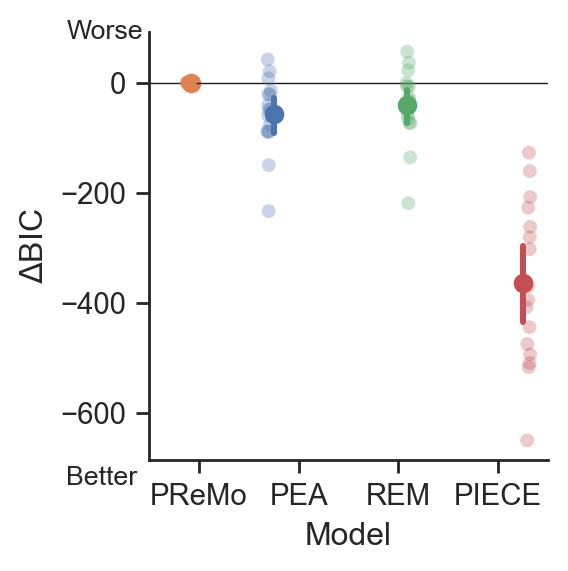

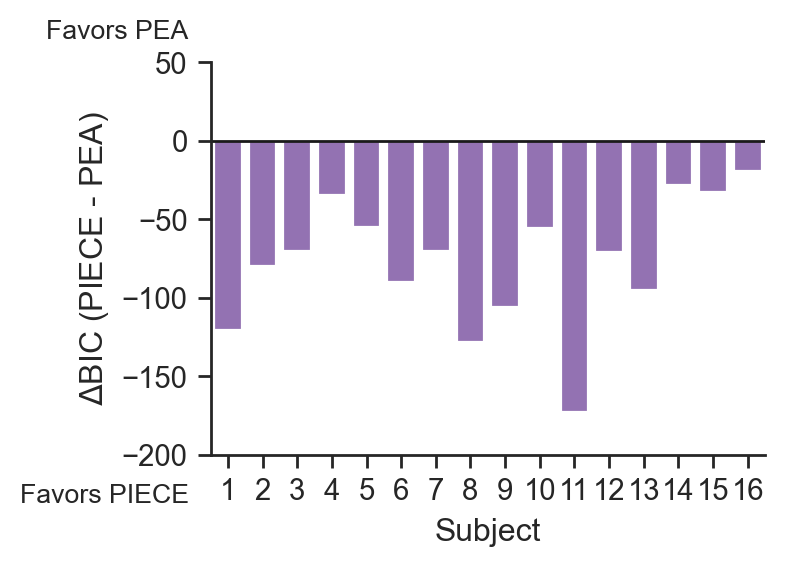

In [30]:
fig_bic, ax = plt.subplots(figsize=(3, 3))
sns.despine()
sns.stripplot(
    data=fits, x="model", y="delta_bic", dodge=True, alpha=0.3, hue="model", 
    legend=False, order=["premo", "pea", "rem", "piece"], ax=ax
)
sns.pointplot(
    data=fits, x="model", y="delta_bic", hue="model", dodge=0.5,
    order=["premo", "pea", "rem", "piece"], **{"linestyle":"none"},
    legend=False, ax=ax
)
ax.axhline(y=0, color="k", linewidth=0.5)
ax.set(ylabel=r"$\Delta$BIC", xticklabels=["PReMo", "PEA", "REM", "PIECE"], xlabel="Model")
ax.text(-1.33, 80, "Worse", fontsize="small")
ax.text(-1.33, -730, "Better", fontsize="small")
plt.tight_layout()

fig_comp, ax = plt.subplots(figsize=(4.25, 3))
sns.barplot(
    data=fits, x="subj_num", y="piece_v_pea", errorbar=None, color="tab:purple", 
    ax=ax
)
ax.axhline(c="k", linewidth=1)
ax.set(ylim=(-200, 50), xlabel="Subject", ylabel=r"$\Delta$BIC (PIECE - PEA)")
ax.text(-6, -230, "Favors PIECE", fontsize="small")
ax.text(-5.25, 65, "Favors PEA", fontsize="small")
sns.despine()
plt.tight_layout()

In [14]:
# fig_bic.savefig("images/bic.png", dpi=300)
# fig_comp.savefig("images/piece-vs-pea.png", dpi=300)

---
# Plot Models using MLEs ($\hat{\Theta}_{\text{MLE}}$) 

In [26]:
# Choose a sample subject
sid = 16
sample_subj = df.loc[df["SN"] == sid, :].reset_index(drop=True)
sigma_motor = sample_subj.loc[0, "motor_sd"]

# Pull out best-fit params for chosen subject:
params_idx = fits["subj_num"] == sid 
params = fits.loc[params_idx, ["theta", "model"]].iloc[0:5, :].reset_index(drop=True)

# Pull out MLEs for each model
pea_mle = params.loc[params["model"] == "pea", "theta"].values[0]
premo_mle = params.loc[params["model"] == "premo", "theta"].values[0]
piece_mle = params.loc[params["model"] == "piece", "theta"].values[0]
rem_mle = params.loc[params["model"] == "rem", "theta"].values[0]

# Find perturbation trials
pert_indices = np.flatnonzero(sample_subj["perturbation"])

# Simulate with best-fit parameters
# PIECE model
_, xhat_piece = piece(
    piece_mle[0], 
    piece_mle[1], 
    piece_mle[2], 
    sigma_motor, len(sample_subj), 
    sample_subj["fbi"], 
    sample_subj["rotation"],
    fit=False
)
adapt_piece = xhat_piece[pert_indices + 1] - xhat_piece[pert_indices - 1]

# PEA model
_, xhat_pea = pea(
    pea_mle[0], 
    pea_mle[1], 
    sigma_motor, len(sample_subj), 
    sample_subj["fbi"], 
    sample_subj["rotation"],
    fit=False
)
adapt_pea = xhat_pea[pert_indices + 1] - xhat_pea[pert_indices - 1]

# PReMo 
_, xhat_premo = premo(
    premo_mle[0],
    premo_mle[1],
    premo_mle[2], 
    premo_mle[3],
    premo_mle[4], 
    sigma_motor, len(sample_subj), 
    sample_subj["fbi"], 
    sample_subj["rotation"],
    fit=False
)
adapt_premo = xhat_premo[pert_indices + 1] - xhat_premo[pert_indices - 1]

# REM
_, xhat_rem = rem(
    rem_mle[0],
    rem_mle[0],
    rem_mle[0], 
    rem_mle[0], 
    sigma_motor, len(sample_subj), 
    sample_subj["fbi"], 
    sample_subj["rotation"],
    fit=False
)
adapt_rem = xhat_rem[pert_indices + 1] - xhat_rem[pert_indices - 1]

# Create data frame with all perturbation trials
df1 = pd.DataFrame({
    "rotation":sample_subj.loc[pert_indices, "rotation"],
    "xhat_ssm":xhat_ssm[pert_indices],
    "adapt_ssm":adapt_ssm,
    "xhat_piece":xhat_piece[pert_indices],
    "adapt_piece":adapt_piece,
    "xhat_pea":xhat_pea[pert_indices],
    "adapt_pea":adapt_pea,
    "xhat_premo":xhat_premo[pert_indices],
    "adapt_premo":adapt_premo,
    "xhat_rem":xhat_rem[pert_indices], 
    "adapt_rem":adapt_rem
})


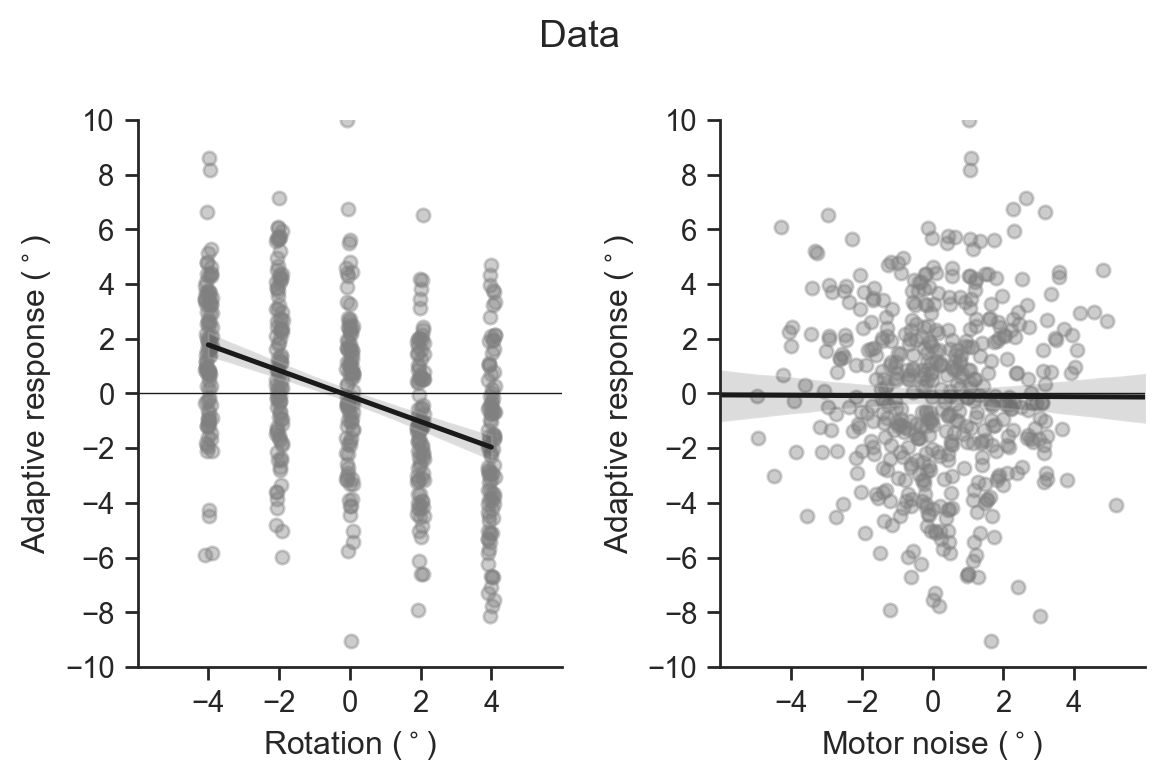

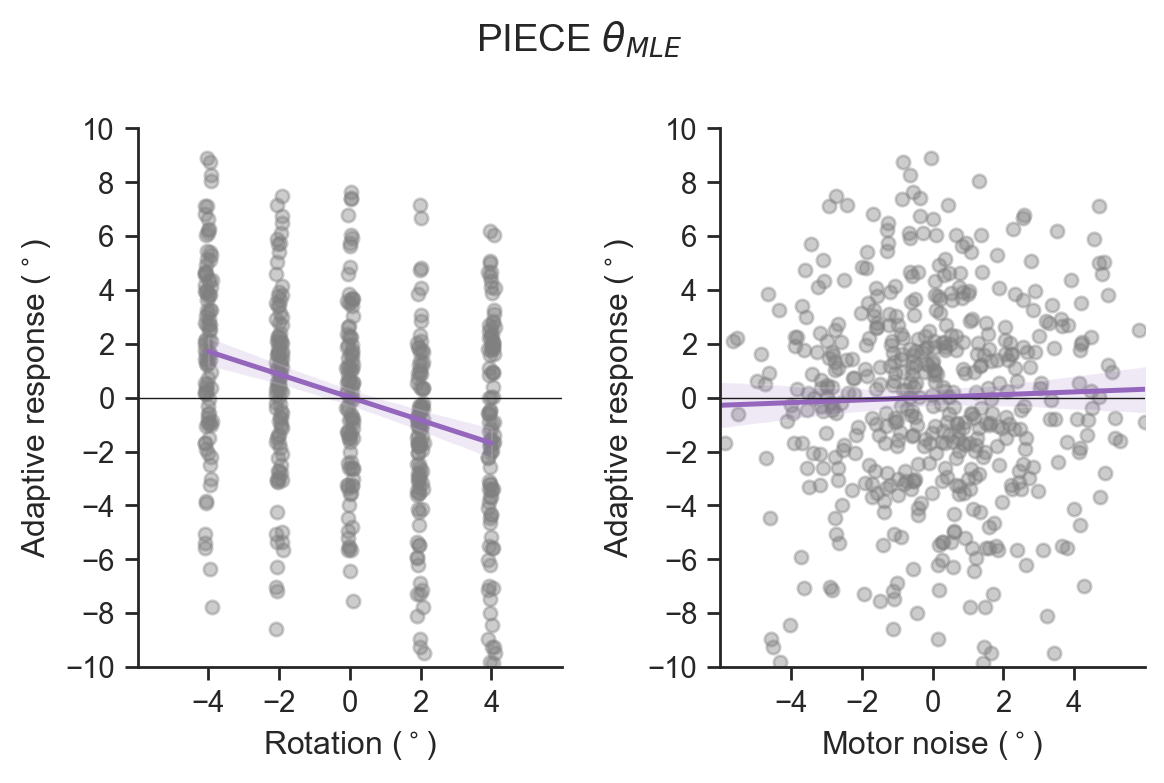

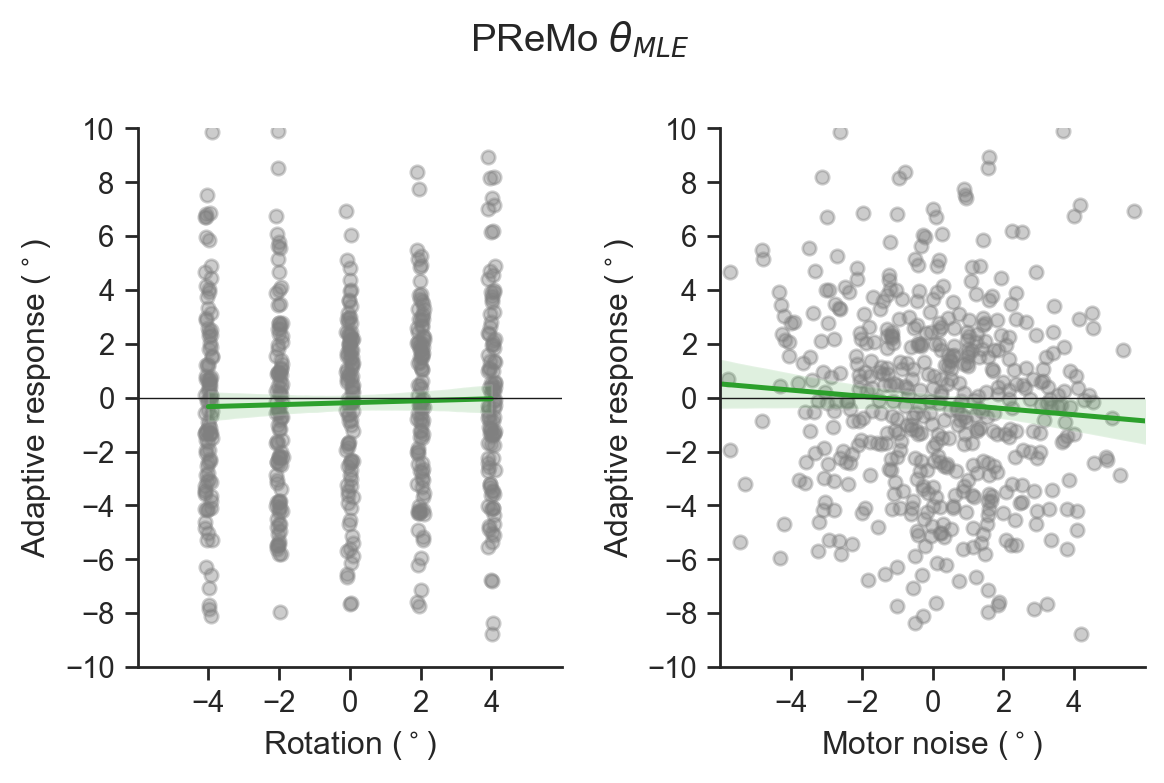

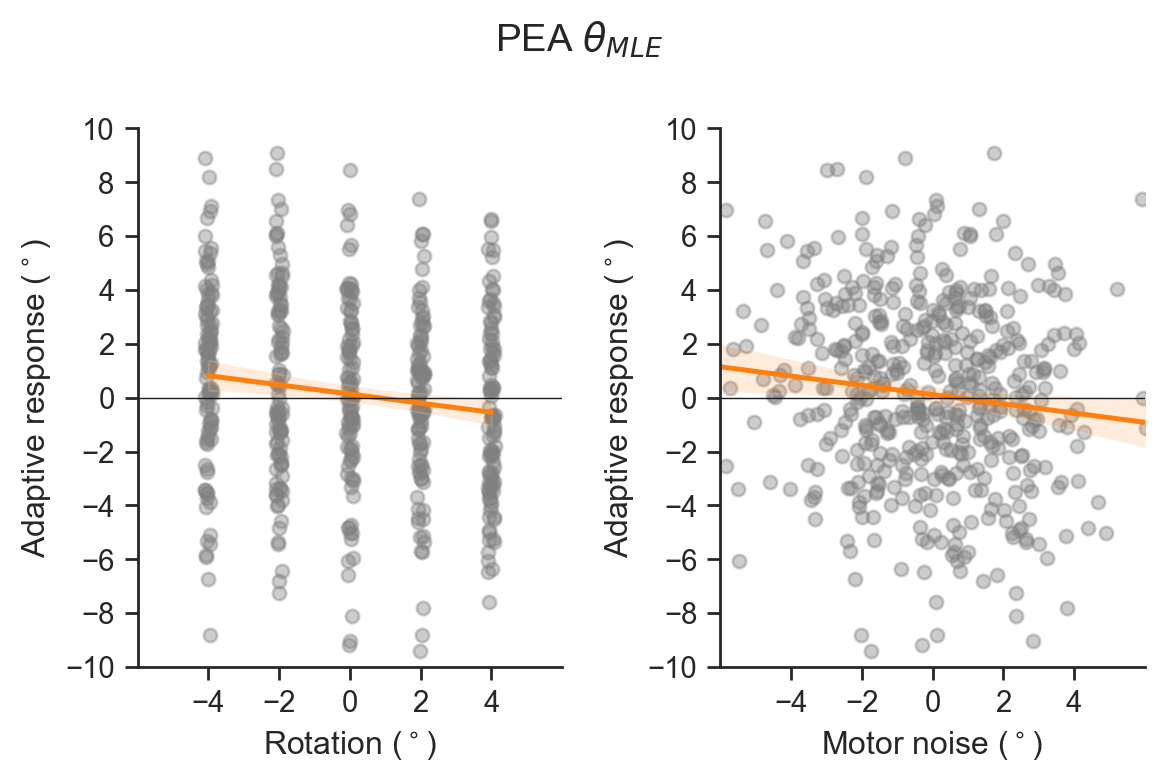

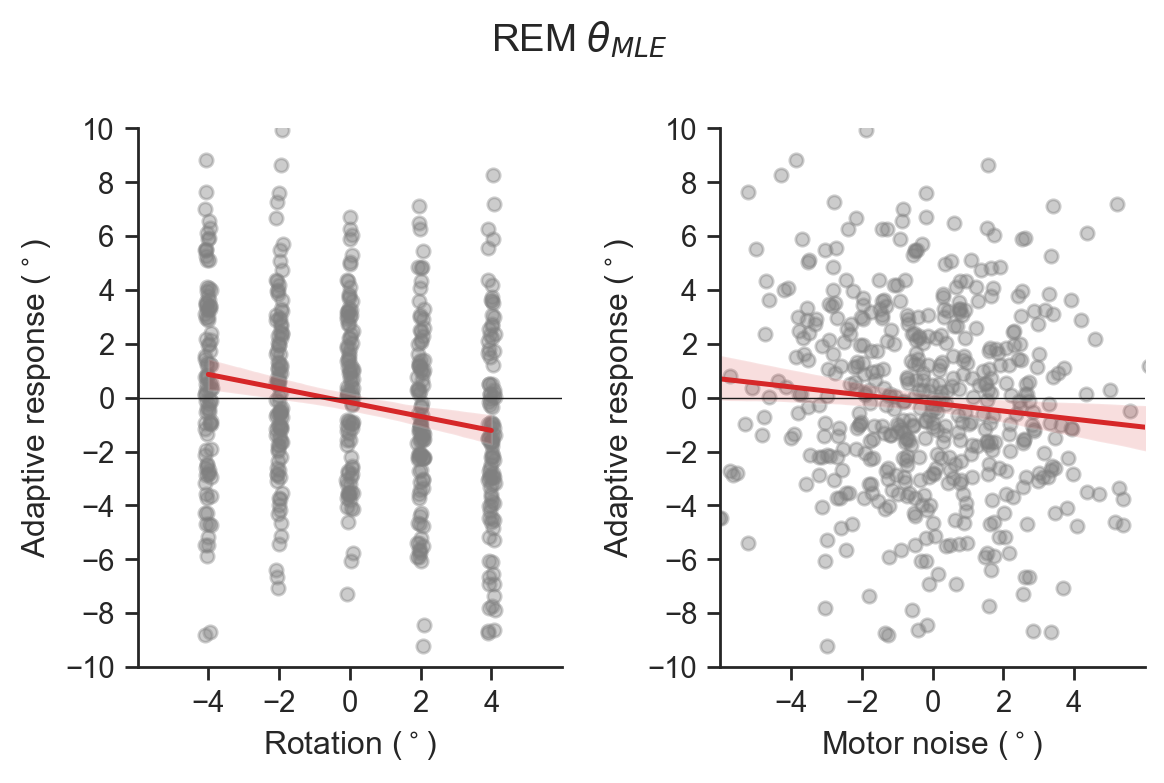

In [27]:
# Assign colors to models
premo_color = "tab:green"
piece_color = "tab:purple"
pea_color = "tab:orange"
rem_color = "tab:red"

# Plot best-fits
fig1 = plot_individual(sample_subj, "rotation", "theta_maxradv_clean", "adaptation", title="Data")
fig2 = plot_individual(df1, "rotation", "xhat_piece", "adapt_piece", piece_color, r"PIECE $\theta_{MLE}$")
fig3 = plot_individual(df1, "rotation", "xhat_premo", "adapt_premo", premo_color, r"PReMo $\theta_{MLE}$")
fig4 = plot_individual(df1, "rotation", "xhat_pea", "adapt_pea", pea_color, r"PEA $\theta_{MLE}$")
fig5 = plot_individual(df1, "rotation", "xhat_rem", "adapt_rem", rem_color, r"REM $\theta_{MLE}$")


In [17]:
# fig1.savefig("images/s6-real-color.png", dpi=300)
# fig2.savefig("images/s6-piece-color.png", dpi=300)
# fig3.savefig("images/s6-premo-color.png", dpi=300)
# fig4.savefig("images/s6-pea-color.png", dpi=300)
# fig5.savefig("images/s6-rem-color.png", dpi=300)